In [1]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.interpolate
import scipy.ndimage
import scipy.special

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit

In [2]:
fname_0 = 'eyepiece_nonuniformities_without_eyeroll.csv'
fname_1 = 'eyepiece_nonuniformities_with_eyeroll.csv'

In [3]:
# Load the user data
luna_df = pd.read_csv('perceptual_data.csv')
luna_df['nonuniformity'] = (100-luna_df['uniformity'])/(100+luna_df['uniformity'])
luna_df['strongly_worse'] = (luna_df['convresp'] >= 2)
luna_df['any_worse'] = (luna_df['convresp'] >= 1)

In [4]:
# Calculate averages for the different conditions
df = luna_df.copy()

x = {}
y = {}
for crit in ['strongly_worse', 'any_worse']:
    for AR, luning in (('monoar', 'monolune'),
                       ('binoar', 'binolune')):
        df_subset = df.loc[(df['AR'] == AR) & ((df['luning'] == luning) | (df['luning'] == 'nolune'))]

        x[crit, AR], y[crit, AR] = [], []
        for n_idx, n in enumerate(sorted(set(df_subset['nonuniformity']))):
            dat = df_subset[df_subset['nonuniformity']==n][crit]
            x[crit, AR].append(n)
            y[crit, AR].append(dat.mean())

In [5]:
# Gaussian CDF fit, which will be fit to the user data
def cdf_2param(x, mu, sigma):
    return 1/2*(1+math.erf((x-mu)/(sigma*np.sqrt(2))))
cdf_v = np.vectorize(cdf_2param)

# Calculate fits
fits_mean = {}
for crit in ['any_worse', 'strongly_worse']:
    for AR in ('monoar', 'binoar'):
        t = np.linspace(min(x[crit, AR]), max(x[crit, AR]), 1000)
        fit_params = curve_fit(cdf_v, x[crit, AR],
                                      y[crit, AR], p0=[0.5, 2])[0]
        fits_mean[crit, AR] = fit_params

In [6]:
# Calculate the nonuniformity for a given threshold
def f_nonuniformity(P, mu, sigma):
    return np.sqrt(2)*sigma*scipy.special.erfinv(2*P-1)+mu

target_nonuniformity = lambda crit, AR, x, : f_nonuniformity(x, *fits_mean[crit, AR])

In [7]:
# Load the eyepiece nonuniformities
eyepiece_0_csv = pd.read_csv(fname_0, header=5)
eyepiece_1_csv = pd.read_csv(fname_1, header=5)

In [8]:
def rescale_data(eyepiece, data_source=None, scale_data=None):
    if data_source is None:
        data_source = 'nonuniformity'
    if scale_data is None:
        scale_data = 5

    x_orig = eyepiece[['x']].to_numpy().squeeze()
    y_orig = eyepiece[['y']].to_numpy().squeeze()
    z_orig = eyepiece[['z']].to_numpy().squeeze()
    m_orig = eyepiece[[data_source]].to_numpy().squeeze()

    x = np.array(list(sorted(np.unique(x_orig))))
    y = np.array(list(sorted(np.unique(y_orig))))
    z = np.array(list(sorted(np.unique(z_orig))))

    X,Y,Z = np.meshgrid(x, y, z)

    M = scipy.interpolate.griddata((x_orig, y_orig, z_orig), m_orig, (X, Y, Z), method='linear')

    if scale_data:
        M = scipy.ndimage.zoom(M, [scale_data, scale_data, scale_data], output=None, order=3,
                               mode='nearest', prefilter=True)
        x = np.linspace(min(x), max(x), int(len(x)*scale_data))
        y = np.linspace(min(y), max(y), int(len(y)*scale_data))
        z = np.linspace(min(z), max(z), int(len(z)*scale_data))
        
    return [x, y, z, M]

# Calculate the smoothed data
data_0 = rescale_data(eyepiece_0_csv)
data_1 = rescale_data(eyepiece_1_csv)

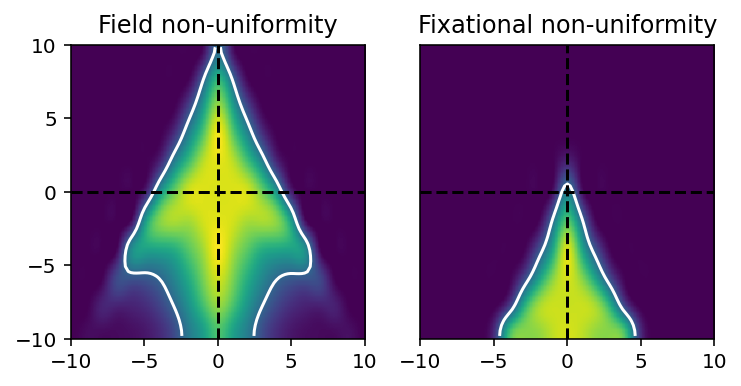

In [9]:
# Plot
f, ax_all = plt.subplots(1, 2, figsize=(5.25, 3.2), dpi=144)

# Take central slice for x-z plane
x, y, z, N = data_0
target_y = np.median(data_0[1])
idx = np.argmin(np.abs(data_0[1] - target_y))
extent = [min(x), max(x), min(z)-np.mean(z), max(z)-np.mean(z)]

thresh = target_nonuniformity('any_worse', 'binoar', 0.75)

ax = ax_all[0]
data = data_0[3][:,idx,:].copy()
data = np.rot90(data, 1)
im = ax.imshow(data, vmin=0, vmax=1, cmap='viridis_r', extent=extent)
ax.contour(data, [thresh, ], colors=['white',], origin='upper', extent=extent)
ax.plot([-10, 10], [0, 0], 'k--')
ax.plot([0, 0], [-10, 10], 'k--')
ax.set_yticks(np.linspace(-10, 10, 5))
ax.set_title('Field non-uniformity')

ax = ax_all[1]
data = data_1[3][:,idx,:].copy()
data = np.rot90(data, 1)
im = ax.imshow(data, vmin=0, vmax=1, cmap='viridis_r', extent=extent)
ax.contour(data, [thresh, ], colors=['white',], origin='upper', extent=extent)
ax.plot([-10, 10], [0, 0], 'k--')
ax.plot([0, 0], [-10, 10], 'k--')
ax.set_yticks([])
ax.set_title('Fixational non-uniformity')

plt.tight_layout()

plt.show()